In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43022 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:33611 Dashboard: http://127.0.0.1:43022/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
from sklearn.mixture import GaussianMixture as GMM
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                   % (0,6)))
dsp

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 315.0 316.0 317.0
Data variables:
    upPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp2    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp3    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp2    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp3    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>

In [6]:
ncoars = 4
upP0p = dsp.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP0p = dsp.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP1p = dsp.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP1p = dsp.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP2p = dsp.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP2p = dsp.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP3p = dsp.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP3p = dsp.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()

In [8]:
upP0p.isel(Z=0).data.ravel().shape

(458752,)

In [7]:
iZ = 0
X = upP0p.isel(Z=iZ).data.ravel().reshape((458752,1))
X = np.concatenate((X,vpP0p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,upP1p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,vpP1p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,upP2p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,vpP2p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,upP3p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X = np.concatenate((X,vpP3p.isel(Z=iZ).data.ravel().reshape((458752,1))),axis=1)
X

dask.array<concatenate, shape=(458752, 8), dtype=float32, chunksize=(65536, 1), chunktype=numpy.ndarray>

In [8]:
gm = GMM(n_components=6, random_state=0, n_init=4, max_iter=200).fit(X)
gm.means_

array([[-7.61027873e-05, -4.03538466e-05,  1.90325135e-05,
        -3.38437751e-04, -1.98377240e-04, -4.63180315e-05,
         1.15565742e-05,  1.64581192e-04],
       [-6.15119937e-03, -9.21902861e-05, -4.40783076e-04,
        -5.61148087e-03,  7.05465210e-03,  3.34754097e-04,
        -3.04979851e-04, -6.54878711e-03],
       [-5.93302553e-02, -3.49349565e-04, -5.63131741e-04,
         5.13644754e-03,  4.12621568e-02, -5.31684061e-06,
        -2.66845891e-03,  1.90931301e-03],
       [-2.88825989e-02,  1.34121432e-03, -1.72003025e-04,
        -3.48019476e-03,  3.52874386e-02, -1.92523771e-03,
        -5.00994616e-04,  1.32600415e-02],
       [-7.44587593e-03, -1.70776827e-04,  5.43044638e-05,
        -4.40971404e-03,  7.34019585e-03, -1.09651596e-04,
        -8.42304576e-05,  6.82409474e-03],
       [ 2.67228505e-02,  1.97631328e-03, -1.51111210e-02,
        -7.32541245e-02, -6.87201342e-02,  2.03867503e-04,
         5.62654333e-03,  9.18147027e-02]])

In [9]:
ds1 = xr.open_zarr(op.join(rund,"EddyFlux002/%03d-%03d" 
                   % (0,6)))
ncoars = 4
upP0pt = ds1.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP0pt = ds1.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP1pt = ds1.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP1pt = ds1.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP2pt = ds1.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP2pt = ds1.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
upP3pt = ds1.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpP3pt = ds1.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()

Y = upP0pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))
Y = np.concatenate((Y,vpP0pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,upP1pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,vpP1pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,upP2pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,vpP2pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,upP3pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)
Y = np.concatenate((Y,vpP3pt.isel(time=0,Z=iZ).data.ravel().reshape((int(256*256),1))),axis=1)

In [10]:
category = np.reshape(gm.predict(Y), (256,256))

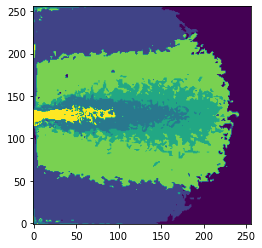

In [11]:
plt.imshow(category, origin='lower')

In [10]:
# Convert to netcdf for transport
dtt = 7
ncoars = 4
ttstart = 0


for tt in range(ttstart,int(56/dtt)+1):

    if tt < 44:
        dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                                   % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                                   % (308,311)))
    
    if tt == 0:
#         upqp = dsp.upqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
#         vpqp = dsp.vpqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP0p = dsp.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP0p = dsp.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP1p = dsp.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP1p = dsp.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP2p = dsp.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP2p = dsp.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP3p = dsp.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP3p = dsp.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    else:
#         upqp = xr.concat([upqp, dsp.upqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
#                          ], 'time')
#         vpqp = xr.concat([vpqp, dsp.vpqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
#                          ], 'time')
        upP0p = xr.concat([upP0p, dsp.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP0p = xr.concat([vpP0p, dsp.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP1p = xr.concat([upP1p, dsp.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP1p = xr.concat([vpP1p, dsp.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP2p = xr.concat([upP2p, dsp.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP2p = xr.concat([vpP2p, dsp.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP3p = xr.concat([upP3p, dsp.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP3p = xr.concat([vpP3p, dsp.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')

    dsp.close()
    print(tt)

0
1
2
3
4
5
6
7
8


In [14]:
iZ = 2
X = upP0p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))
X = np.concatenate((X,vpP0p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,upP1p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,vpP1p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,upP2p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,vpP2p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,upP3p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X = np.concatenate((X,vpP3p.isel(Z=iZ).data.ravel().reshape((int(63*256*256),1))),axis=1)
X

dask.array<concatenate, shape=(4128768, 8), dtype=float32, chunksize=(65536, 1), chunktype=numpy.ndarray>

In [15]:
nGMM = 4
gm = GMM(n_components=nGMM, random_state=0, n_init=4, max_iter=200).fit(X)

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


<xarray.DataArray (time: 7, YC: 256, XC: 256)>
dask.array<xarray-<this-array>, shape=(7, 256, 256), dtype=int64, chunksize=(7, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float32 622.0 623.0 624.0 625.0 626.0 627.0 628.0


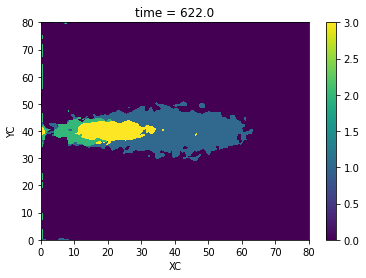

0


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


1


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


2


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


3


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


4


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


5


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


27


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


28


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


29


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


30


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


31


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


32


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


33


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


34


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


35


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


36


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


37


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


38


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


39


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


40


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


41


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


42


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


43


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


44


In [16]:
# Convert to netcdf for transport
dtt = 7
ncoars = 4
# ttstart = int(56/dtt)+1
ttstart = 0


for tt in range(ttstart,int(312/dtt)+1):
# for tt in range(ttstart,9):

    if tt < 44:
        dspt = xr.open_zarr(op.join(rund,"EddyFlux002/%03d-%03d" 
                                    % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dspt = xr.open_zarr(op.join(rund,"EddyFlux002/%03d-%03d" 
                                    % (308,311)))
    
    upP0pt = dspt.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    vpP0pt = dspt.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    upP1pt = dspt.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    vpP1pt = dspt.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    upP2pt = dspt.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    vpP2pt = dspt.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    upP3pt = dspt.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    vpP3pt = dspt.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()

    Y = upP0pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))
    Y = np.concatenate((Y,vpP0pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,upP1pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,vpP1pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,upP2pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,vpP2pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,upP3pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,vpP3pt.isel(Z=iZ).data.ravel().reshape((len(dspt.time),int(256*256),1))),axis=-1)
    
    for i in range(len(dspt.time)):
        if i == 0:
            category = np.reshape(gm.predict(Y[i]),(1,256,256))
        else:
            category = np.concatenate((category, np.reshape(gm.predict(Y[i]),(1,256,256))),
                                      axis=0)
    category = xr.DataArray(category, dims=upP0pt.isel(Z=iZ).dims, 
                            coords=upP0pt.isel(Z=iZ).coords
                           ).chunk({'YC':128,'XC':128}).reset_coords(drop=True)
    if tt == ttstart:
        print(category)
        category.isel(time=0).plot()
        plt.show()
    category.to_dataset(name='category').to_zarr(op.join(rund,'EddyFlux002/GMM%02d/%03d-%03d/Z%02d/'
                                                         % (nGMM,tt*dtt,tt*dtt+len(dspt.time)-1,iZ)),
                                                 mode='w')
    dspt.close()
    print(tt)

In [19]:
ds2 = xr.open_zarr(op.join(rund,'EddyFlux002/GMM%02d/%03d-%03d/Z%02d/'
                           % (4,70,76,2)))
category = ds2.category

category

<xarray.DataArray 'category' (time: 7, YC: 256, XC: 256)>
dask.array<open_dataset-aa27cd60afe37493083b9e8defcd6affcategory, shape=(7, 256, 256), dtype=int64, chunksize=(7, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float32 692.0 693.0 694.0 695.0 696.0 697.0 698.0

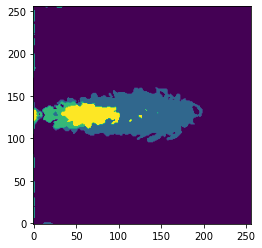

In [20]:
plt.imshow(category[0], origin='lower')

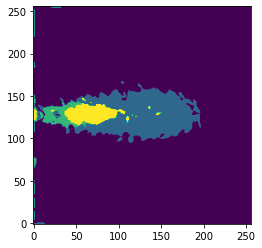

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


In [21]:
plt.imshow(category[-1], origin='lower')

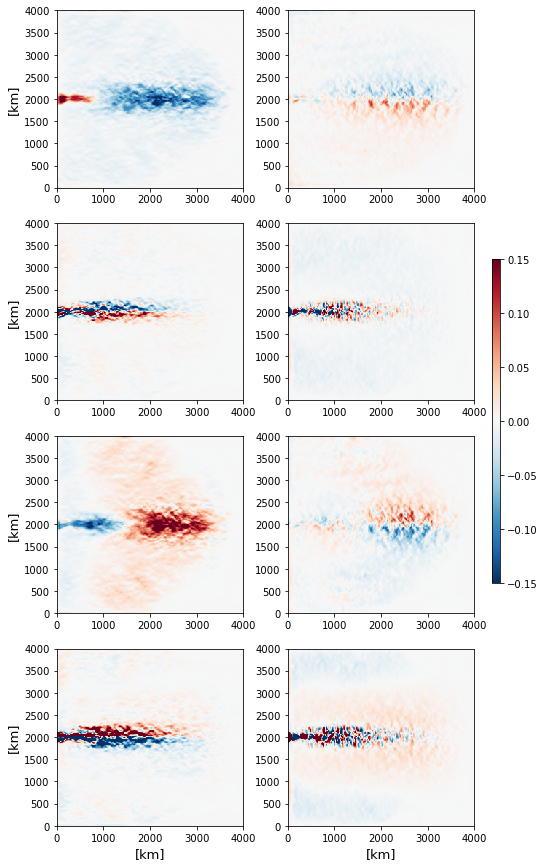

In [16]:
fig, axes = plt.subplots(figsize=(8,15), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(upP0pt.XC*Rd*1e-3, upP0pt.YC*Rd*1e-3, upP0pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(vpP0pt.XC*Rd*1e-3, vpP0pt.YC*Rd*1e-3, vpP0pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(upP1pt.XC*Rd*1e-3, upP1pt.YC*Rd*1e-3, upP1pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(vpP1pt.XC*Rd*1e-3, vpP1pt.YC*Rd*1e-3, vpP1pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(upP2pt.XC*Rd*1e-3, upP2pt.YC*Rd*1e-3, upP2pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(vpP2pt.XC*Rd*1e-3, vpP2pt.YC*Rd*1e-3, vpP2pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(upP3pt.XC*Rd*1e-3, upP3pt.YC*Rd*1e-3, upP3pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(vpP3pt.XC*Rd*1e-3, vpP3pt.YC*Rd*1e-3, vpP3pt.isel(time=0,Z=0),
                          vmax=.15, vmin=-.15, cmap='RdBu_r', rasterized=True)

axes[0,0].set_ylabel(r"[km]", fontsize=13)
axes[1,0].set_ylabel(r"[km]", fontsize=13)
axes[2,0].set_ylabel(r"[km]", fontsize=13)
axes[3,0].set_ylabel(r"[km]", fontsize=13)
axes[3,0].set_xlabel(r"[km]", fontsize=13)
axes[3,1].set_xlabel(r"[km]", fontsize=13)

fig.subplots_adjust(right=0.85, wspace=.24)
cbaxes = fig.add_axes([0.88, 0.35, 0.015, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
plt.savefig(op.join(rund,'Figs/eddyPTRflux_4coars_007.pdf'))

In [60]:
def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

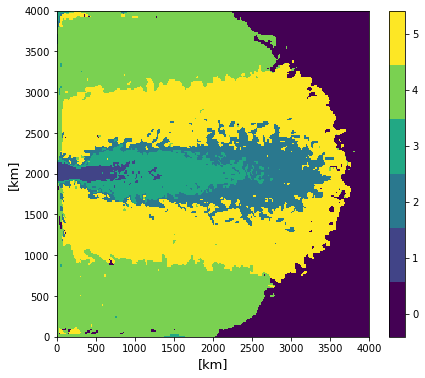

In [68]:
cat = xr.open_zarr(op.join(rund,'EddyFlux001/GMM%02d/%03d-%03d/Z%02d/'
                           % (6,63,69,0))
                  ).category

fig,ax = plt.subplots(figsize=(7,6))
# fig.set_tight_layout(True)

cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(cat.XC*Rd*1e-3, cat.YC*Rd*1e-3, cat.isel(time=0), 
                   cmap=cmap, rasterized=True
                  )
# for c in im.collections:
#     c.set_rasterized(True)
# cbar = fig.colorbar(im, shrink=.7, 
#                     ticks=[.4,1.2,2.,2.8,3.6,4.4]
#                    )
colorbar_index(ncolors=6, cmap=cmap)  
# cbar.ax.set_yticklabels([0,1,2,3,4,5])
ax.set_xlabel(r"[km]", fontsize=13)
ax.set_ylabel(r"[km]", fontsize=13)
plt.savefig(op.join(rund,'Figs/eddyPTRflux_4coars_007_category.pdf'))